In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from triplet_mnist_loader import MNIST_t
import torch.nn.functional as F

batch_size = 120
epochs = 10
no_cuda = False
seed = 1
log_interval = 50
margin = 0.2
cuda = not no_cuda and torch.cuda.is_available()


torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        MNIST_t('../data', train=False, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if cuda:
    model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MarginRankingLoss(margin = margin)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb - margin).cpu().data
    return (pred > 0).sum()*1.0/dista.size()[0]

def plot(data1, recon_batch1):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    data = data1.data.numpy()
    predict = recon_batch1.data.numpy()
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i][0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predict[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

train_loss_metric = []
train_loss_VAE = []
train_acc_metric = []
test_loss_metric = []
test_loss_VAE = []
test_acc_metric = []

for epoch in range(1, epochs + 1):
    losses_metric = AverageMeter()
    losses_VAE = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()

    model.train()
    for batch_idx, (data1, data2, data3) in enumerate(train_loader):
        if cuda:
            data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

        recon_batch1, mu1, logvar1 = model(data1)
        recon_batch2, mu2, logvar2 = model(data2)
        recon_batch3, mu3, logvar3 = model(data3)

        loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
        loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
        loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
        loss_vae = loss_vae/(3*len(data1))

        dista = F.pairwise_distance(mu1, mu2, 2)
        distb = F.pairwise_distance(mu1, mu3, 2)
        target = torch.FloatTensor(dista.size()).fill_(1)
        if cuda:
            target = target.cuda()
        target = Variable(target)
        loss_triplet = criterion(dista, distb, target)

        loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

        loss = 0.01*loss_vae + loss_triplet + 0.001*loss_embedd

        # measure accuracy and record loss
        acc = accuracy(dista, distb)
        losses_metric.update(loss_triplet.data[0], data1.size(0))
        losses_VAE.update(loss_vae.data[0], data1.size(0))
        accs.update(acc, data1.size(0))
        emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

        # train
        optimizer.zero_grad()          
        loss.backward()
        optimizer.step()  
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'VAE Loss: {:.4f} ({:.4f}) \t'
                  'Metric Loss: {:.4f} ({:.4f}) \t'
                  'Metric Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                losses_VAE.val, losses_VAE.avg,
                losses_metric.val, losses_metric.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))

            train_loss_metric.append(losses_metric.val)
            train_loss_VAE.append(losses_VAE.val)
            train_acc_metric.append(accs.val)

           # plot(data1, recon_batch1)

            # Test
            model.eval()
            for batch_idx, (data1, data2, data3) in enumerate(test_loader):
                if cuda:
                    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
                data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

                recon_batch1, mu1, logvar1 = model(data1)
                recon_batch2, mu2, logvar2 = model(data2)
                recon_batch3, mu3, logvar3 = model(data3)

                loss_vae = loss_function(recon_batch1, data1, mu1, logvar1)     
                loss_vae += loss_function(recon_batch2, data2, mu2, logvar2)  
                loss_vae += loss_function(recon_batch3, data3, mu3, logvar3)  
                loss_vae = loss_vae/(3*len(data1))

                dista = F.pairwise_distance(mu1, mu2, 2)
                distb = F.pairwise_distance(mu1, mu3, 2)
                target = torch.FloatTensor(dista.size()).fill_(1)
                if cuda:
                    target = target.cuda()
                target = Variable(target)
                loss_triplet = criterion(dista, distb, target)

                loss_embedd = mu1.norm(2) + mu2.norm(2) + mu3.norm(2)

                loss = 0.01*loss_vae + loss_triplet + 0.001*loss_embedd

                # measure accuracy and record loss
                acc = accuracy(dista, distb)
                losses_metric.update(loss_triplet.data[0], data1.size(0))
                losses_VAE.update(loss_vae.data[0], data1.size(0))
                accs.update(acc, data1.size(0))
                emb_norms.update(loss_embedd.data[0]/3, data1.size(0))

            print('\nTest set: Average VAE loss: {:.4f}, Average Metric loss: {:.4f}, Metric Accuracy: {:.2f}%\n'.format(
            losses_VAE.avg, losses_metric.avg, 100. * accs.avg))
            test_loss_metric.append(losses_metric.avg)
            test_loss_VAE.append(losses_VAE.avg)
            test_acc_metric.append(accs.avg)

           # plot(data1, recon_batch1)


Processing Triplet Generation ...
Done!
Processing Triplet Generation ...
Done!
Train Epoch: 1 [0/60000]	VAE Loss: 549.0289 (549.0289) 	Metric Loss: 0.1655 (0.1655) 	Metric Acc: 68.33% (68.33%) 	Emb_Norm: 3.98 (3.98)

Test set: Average VAE loss: 522.3603, Average Metric loss: 0.1286, Metric Accuracy: 74.62%

Train Epoch: 1 [6000/60000]	VAE Loss: 204.6201 (427.5429) 	Metric Loss: 0.0458 (0.1015) 	Metric Acc: 90.00% (79.83%) 	Emb_Norm: 8.43 (6.88)

Test set: Average VAE loss: 344.6658, Average Metric loss: 0.0748, Metric Accuracy: 85.13%

Train Epoch: 1 [12000/60000]	VAE Loss: 200.0004 (318.8199) 	Metric Loss: 0.0147 (0.0665) 	Metric Acc: 97.50% (86.75%) 	Emb_Norm: 12.64 (8.00)

Test set: Average VAE loss: 290.8805, Average Metric loss: 0.0576, Metric Accuracy: 88.58%

Train Epoch: 1 [18000/60000]	VAE Loss: 185.6355 (278.7062) 	Metric Loss: 0.0679 (0.0556) 	Metric Acc: 90.83% (89.17%) 	Emb_Norm: 26.15 (10.50)

Test set: Average VAE loss: 261.8416, Average Metric loss: 0.0533, Metric Accu

# Plot learning curves

(array([ 0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05]),
 <a list of 9 Text yticklabel objects>)

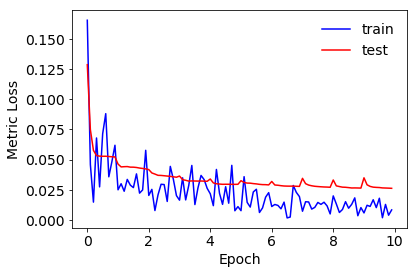

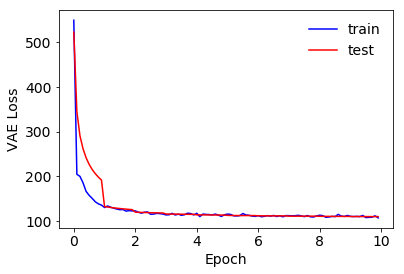

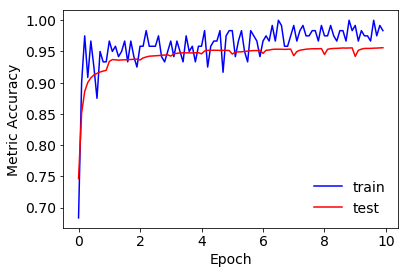

In [20]:
import matplotlib.pyplot as plt
import numpy as np

steps = log_interval * np.arange(0, len(test_loss_metric)) / 500.

plt.figure()
plt.plot(steps, train_loss_metric, color = 'b')
plt.plot(steps, test_loss_metric, color = 'red')
font_size = 14
plt.legend(['train', 'test'], loc = 0, frameon=False, fontsize=font_size)
plt.xlabel('Epoch', fontsize = font_size)
plt.ylabel('Metric Loss', fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)

plt.figure()
plt.plot(steps, train_loss_VAE, color = 'b')
plt.plot(steps, test_loss_VAE, color = 'red')
font_size = 14
plt.legend(['train', 'test'], loc = 0, frameon=False, fontsize=font_size)
plt.xlabel('Epoch', fontsize = font_size)
plt.ylabel('VAE Loss', fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)

plt.figure()
plt.plot(steps, train_acc_metric, color = 'b')
plt.plot(steps, test_acc_metric, color = 'red')
font_size = 14
plt.legend(['train', 'test'], loc = 0, frameon=False, fontsize=font_size)
plt.xlabel('Epoch', fontsize = font_size)
plt.ylabel('Metric Accuracy', fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)

# Plot metric embeddings

In [33]:
from regular_mnist_loader import MNIST_regular

def feature_space(tnet):   
    # print
    loader = MNIST_regular('../data', download=True, n_train=60000, n_test=10000, 
                  transform=transforms.ToTensor())
               
    # switch to evaluation mode
    tnet.eval()

    data_test, Y_test, data_train, Y_train = loader.getfeature()
    Y_test = np.array(Y_test, dtype = np.int64)
    Y_train = np.array(Y_train, dtype = np.int64)
    
    # compute feature space
    if cuda:
        data_test = data_test.cuda()
        data_train = data_train.cuda()
    data_test = Variable(data_test)
    data_train = Variable(data_train)
    recon_batch_test, mu_test, logvar_test = tnet(data_test)
    recon_batch_train, mu_train, logvar_train = tnet(data_train)
    
    mu_test = mu_test.data.numpy()
    mu_train = mu_train.data.numpy()

    return mu_test, mu_train, Y_test, Y_train

mu_test, mu_train, Y_test, Y_train = feature_space(model)      
np.savez('data_feature', mu_test=mu_test, mu_train=mu_train, Y_test=Y_test, Y_train=Y_train)

In [1]:
# load feature data
import numpy as np
data = np.load('data_feature.npz')
mu_test = data['mu_test']
mu_train = data['mu_train']
Y_test = data['Y_test']
Y_train = data['Y_train']

Automatically created module for IPython interactive environment


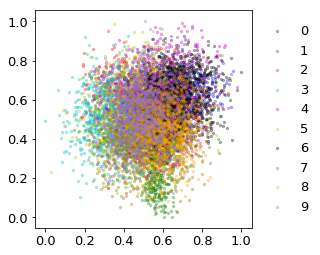

In [2]:
%matplotlib inline
print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

# visualize the embedding vectors
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
    x_min, x_max = np.min(mu, 0), np.max(mu, 0)
    mu = (mu - x_min) / (x_max - x_min)
    
    data = [[] for i in range(10)]
    for i, y in enumerate(Y):
        data[y].append(np.array(mu[i]))
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)
    #alphas = [0, 0.3, 0, 0.3, 0, 0.3, 0, 0.3, 0, 0.3]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
plot_embedding(mu_test[:, 0:2], Y_test)

Computing random projection
Computing PCA projection
Computing Linear Discriminant Analysis projection
Computing t-SNE embedding


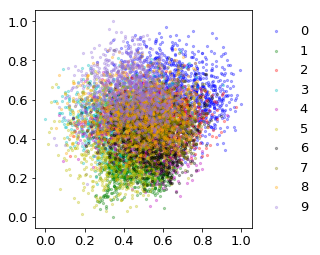

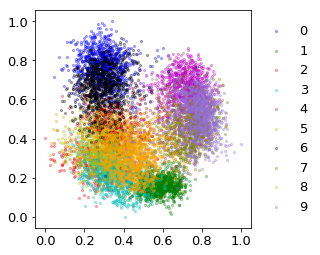

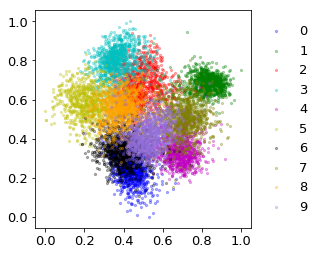

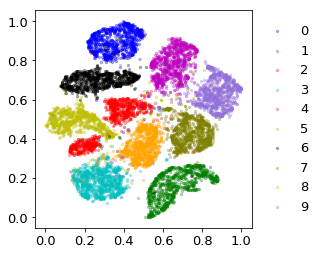

In [4]:
X = mu_test
Y = Y_test

#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=100)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, Y, "Random Projection of the digits")


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, Y, 
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, Y)
plot_embedding(X_lda, Y, 
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, Y,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

## Basic functions

(128, 784)
(28, 28)


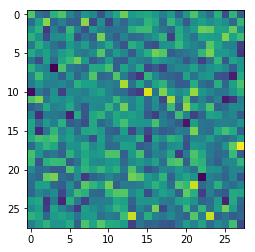

In [41]:
import numpy as np
for batch_idx, (data1, data2, data3) in enumerate(train_loader):
    if cuda:
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
    data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)
              
    recon_batch1, mu1, logvar1 = model(data1)
    recon_batch2, mu2, logvar2 = model(data2)
    recon_batch3, mu3, logvar3 = model(data3)
    
    print(np.shape(recon_batch1.data.numpy()))
    data = data1.data.numpy()
    predict = recon_batch1.data.numpy()
    print(np.shape(data[0][0]))
    plt.imshow(data[0][0])
    plt.imshow(predict[0].reshape(28, 28))
    break